# Palantir IV Smile – Earnings Event Study

We study Palantir’s (PLTR) options implied volatility (IV) smile around earnings. Using a ~30-day expiry, we compute the implied move two ways—(i) ATM IV × √T and (ii) ATM short-straddle premium/spot and compare to the realised move across the event window. We include a short-straddle payoff illustration to explain why volatility crush can benefit premium sellers when realised move is smaller than implied. (Research only; ignores costs, margin, assignment risk.)

### 0) Setup

In [1]:
# --- Setup
import os
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, timezone

os.makedirs("figures", exist_ok=True)


plt.rcParams['figure.dpi'] = 120
plt.rcParams['savefig.dpi'] = 300

TICKER = "PLTR"
EARN_DATE = "2025-08-04"   # earnings after close 2025-08-04 -> next day move
stk = yf.Ticker(TICKER)

# Convenience: current spot
hist_1y = stk.history(period="1y")
spot = float(hist_1y["Close"].iloc[-1])
spot


156.7100067138672

### 1) Expiry selection

In [2]:
# --- Choose an expiry nearest to a target number of days from today
def choose_expiry_near_days(expiries, target_days=30):
    if not expiries:
        return None
    now = datetime.utcnow().replace(tzinfo=timezone.utc)
    def days_abs(d):
        dt = datetime.strptime(d, "%Y-%m-%d").replace(tzinfo=timezone.utc)
        return abs((dt - now).days)
    return sorted(expiries, key=days_abs)[0]

expiries = stk.options or []
expiry = choose_expiry_near_days(expiries, target_days=30)
expiry


C:\Users\crowe\AppData\Local\Temp\ipykernel_17004\3401312556.py:5: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.utcnow().replace(tzinfo=timezone.utc)


'2025-09-05'

### 2) Chain

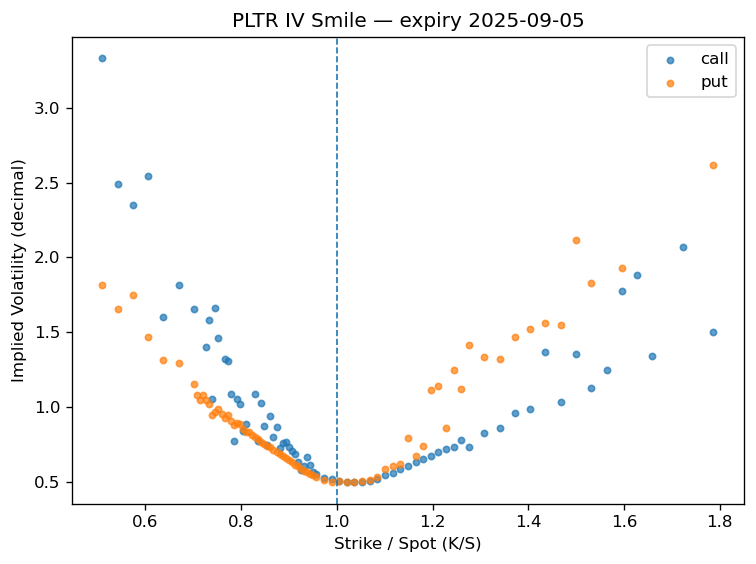

In [3]:
# --- Prepare a chain DataFrame
def prep_chain(chain_df: pd.DataFrame, typ: str, spot: float) -> pd.DataFrame:
    if chain_df is None or chain_df.empty:
        return pd.DataFrame()
    keep = [c for c in ["contractSymbol","strike","lastPrice","bid","ask","impliedVolatility"] if c in chain_df.columns]
    out = chain_df[keep].copy()
    out["type"] = typ
    out["moneyness"] = out["strike"] / spot
    out["iv"] = out["impliedVolatility"]
    # Mid price fallback
    bid = out.get("bid", pd.Series(index=out.index, dtype=float)).fillna(0.0)
    ask = out.get("ask", pd.Series(index=out.index, dtype=float)).fillna(0.0)
    last = out.get("lastPrice", pd.Series(index=out.index, dtype=float)).fillna(np.nan)
    mid = (bid + ask) / 2.0
    out["mid"] = np.where((bid > 0) & (ask > 0), mid, last)
    return out.dropna(subset=["iv", "strike"])

chain = stk.option_chain(expiry) if expiry else None
calls = prep_chain(getattr(chain, "calls", None), "call", spot)
puts  = prep_chain(getattr(chain, "puts",  None), "put",  spot)
opt = pd.concat([calls, puts], ignore_index=True) if expiry else pd.DataFrame()

# --- Plot IV vs K/S
fig, ax = plt.subplots()
for typ, g in opt.groupby("type"):
    ax.scatter(g["moneyness"], g["iv"], s=14, alpha=0.7, label=typ)
ax.axvline(1.0, linestyle="--", linewidth=1)
ax.set_xlabel("Strike / Spot (K/S)")
ax.set_ylabel("Implied Volatility (decimal)")
ax.set_title(f"{TICKER} IV Smile — expiry {expiry}")
ax.legend()
plt.tight_layout()
plt.savefig("figures/iv_smile_example.png")
plt.show()


### 3) Implied move from ATM IV

In [4]:
# --- Find nearest-ATM rows and compute T in years
def nearest_by_strike(df: pd.DataFrame, strike_target: float) -> pd.Series:
    return df.iloc[(df["strike"] - strike_target).abs().argsort()[:1]]

atm_call = nearest_by_strike(calls, spot).squeeze() if not calls.empty else None
atm_put  = nearest_by_strike(puts,  spot).squeeze() if not puts.empty  else None

# Year fraction to expiry (simple ACT/365)
expiry_dt = datetime.strptime(expiry, "%Y-%m-%d").replace(tzinfo=timezone.utc)
now = datetime.utcnow().replace(tzinfo=timezone.utc)
T_years = max((expiry_dt - now).days, 0) / 365.0

# ATM IV proxy: mean of call/put IV
atm_iv = float(np.nanmean([atm_call["iv"], atm_put["iv"]])) if (atm_call is not None and atm_put is not None) else np.nan
implied_move_iv = atm_iv * np.sqrt(T_years) if (np.isfinite(atm_iv) and T_years > 0) else np.nan

# Straddle premium proxy and implied move
straddle_prem = float(atm_call["mid"] + atm_put["mid"]) if (atm_call is not None and atm_put is not None) else np.nan
implied_move_straddle = (straddle_prem / spot) if (np.isfinite(straddle_prem) and spot > 0) else np.nan

atm_iv, T_years, implied_move_iv, straddle_prem, implied_move_straddle


C:\Users\crowe\AppData\Local\Temp\ipykernel_17004\1857208333.py:10: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.utcnow().replace(tzinfo=timezone.utc)


(0.5043994873046875,
 0.00821917808219178,
 np.float64(0.0457286975146103),
 7.3500000000000005,
 0.04690191873592462)

### 4) Realised move across the Aug 2025 earnings event

In [6]:
# --- Realised move across earnings with timezone-safe comparisons

from pandas.tseries.offsets import BDay

earn_naive = pd.Timestamp(EARN_DATE)  # e.g., "2025-08-04"
# Pull a window around the event
px = stk.history(
    start=(earn_naive - pd.Timedelta(days=10)).strftime("%Y-%m-%d"),
    end=(earn_naive + pd.Timedelta(days=10)).strftime("%Y-%m-%d"),
)

# Get the timezone used by Yahoo (usually America/New_York). If None, assume UTC.
data_tz = px.index.tz or "UTC"

# Localize the earnings date to the same tz as the price index
earn = pd.Timestamp(EARN_DATE).tz_localize(data_tz)

# Choose previous/next TRADING day relative to the event
pre_cut  = earn - pd.Timedelta(days=1)
post_cut = earn + pd.Timedelta(days=1)

# Guard: ensure index is sorted and tz-aware
px = px.sort_index()

# Select nearest trading sessions
pre_trd_idx  = px.index[px.index <= pre_cut]
post_trd_idx = px.index[px.index >= post_cut]

pre_trd  = pre_trd_idx.max() if len(pre_trd_idx)  else pd.NaT
post_trd = post_trd_idx.min() if len(post_trd_idx) else pd.NaT

pre_close  = float(px.loc[pre_trd, "Close"]) if pre_trd is not pd.NaT else np.nan
post_close = float(px.loc[post_trd, "Close"]) if post_trd is not pd.NaT else np.nan

realized_move = (
    abs(post_close - pre_close) / pre_close
    if (np.isfinite(pre_close) and np.isfinite(post_close))
    else np.nan
)

EARN_DATE, data_tz, pre_trd, post_trd, pre_close, post_close, realized_move


('2025-08-04',
 <DstTzInfo 'America/New_York' LMT-1 day, 19:04:00 STD>,
 Timestamp('2025-08-01 00:00:00-0400', tz='America/New_York'),
 Timestamp('2025-08-05 00:00:00-0400', tz='America/New_York'),
 154.27000427246094,
 173.27000427246094,
 0.12316068888183554)

In [7]:
# Breakeven percentage (per side) for short ATM straddle
breakeven_pct = (straddle_prem / spot) if (np.isfinite(straddle_prem) and spot > 0) else np.nan

def verdict(realized, implied_iv, be):
    lines = []
    if np.isfinite(realized) and np.isfinite(implied_iv):
        lines.append(f"Realized vs ATM_IV*sqrt(T): {'SMALLER' if realized < implied_iv else 'LARGER or equal'}")
    if np.isfinite(realized) and np.isfinite(be):
        lines.append(f"Realized vs Straddle Breakeven: {'SMALLER (favorable)' if realized < be else 'LARGER (unfavorable)'}")
    return " | ".join(lines)

summary = pd.DataFrame({
    "spot_now": [spot],
    "expiry": [expiry],
    "T_years": [T_years],
    "ATM_IV": [atm_iv],
    "ImpliedMove_IV_sqrtT": [implied_move_iv],
    "Straddle_Premium": [straddle_prem],
    "Breakeven_Move_pct": [breakeven_pct],
    "ImpliedMove_Straddle": [implied_move_straddle],
    "Earnings_Date": [EARN_DATE],
    "Realized_Move": [realized_move],
    "Verdict": [verdict(realized_move, implied_move_iv, breakeven_pct)]
})
summary


,spot_now,expiry,T_years,ATM_IV,ImpliedMove_IV_sqrtT,Straddle_Premium,Breakeven_Move_pct,ImpliedMove_Straddle,Earnings_Date,Realized_Move,Verdict
0,156.710007,2025-09-05,0.008219,0.504399,0.045729,7.35,0.046902,0.046902,2025-08-04,0.123161,Realized vs ATM_IV*sqrt(T): LARGER or equal | ...


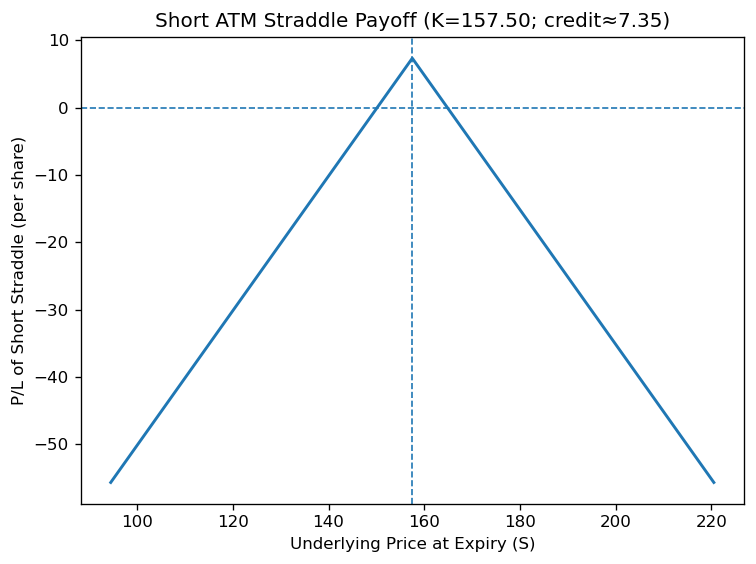

In [8]:
# --- Payoff at expiry for a short ATM straddle (illustrative)
K = float(atm_call["strike"]) if atm_call is not None else spot
C_mid = float(atm_call["mid"]) if atm_call is not None else np.nan
P_mid = float(atm_put["mid"])  if atm_put  is not None else np.nan
credit = C_mid + P_mid

S = np.linspace(K*0.6, K*1.4, 201)  # price at expiry
payoff = credit - np.maximum(S - K, 0) - np.maximum(K - S, 0)

fig, ax = plt.subplots()
ax.plot(S, payoff, linewidth=1.75)
ax.axhline(0, linestyle="--", linewidth=1)
ax.axvline(K, linestyle="--", linewidth=1)
ax.set_xlabel("Underlying Price at Expiry (S)")
ax.set_ylabel("P/L of Short Straddle (per share)")
ax.set_title(f"Short ATM Straddle Payoff (K={K:.2f}; credit≈{credit:.2f})")
plt.tight_layout()
plt.savefig("figures/straddle_payoff.png")
plt.show()


In [9]:
os.makedirs("figures", exist_ok=True)
os.makedirs("docs", exist_ok=True)

# Save summary table to CSV for your report
summary_path = "docs/pltr_event_summary.csv"
summary.to_csv(summary_path, index=False)
summary


,spot_now,expiry,T_years,ATM_IV,ImpliedMove_IV_sqrtT,Straddle_Premium,Breakeven_Move_pct,ImpliedMove_Straddle,Earnings_Date,Realized_Move,Verdict
0,156.710007,2025-09-05,0.008219,0.504399,0.045729,7.35,0.046902,0.046902,2025-08-04,0.123161,Realized vs ATM_IV*sqrt(T): LARGER or equal | ...


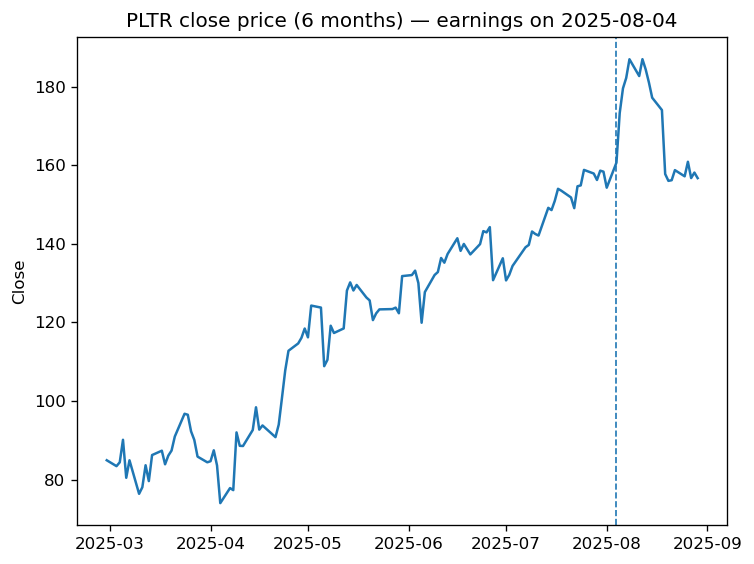

In [10]:
# Price path with event window markers
px_full = stk.history(period="6mo")
fig, ax = plt.subplots()
ax.plot(px_full.index, px_full["Close"], linewidth=1.5)
ax.axvline(pd.Timestamp(EARN_DATE), linestyle="--", linewidth=1)
ax.set_title(f"{TICKER} close price (6 months) — earnings on {EARN_DATE}")
ax.set_ylabel("Close")
plt.tight_layout()
plt.savefig("figures/price_around_earnings.png")
plt.show()


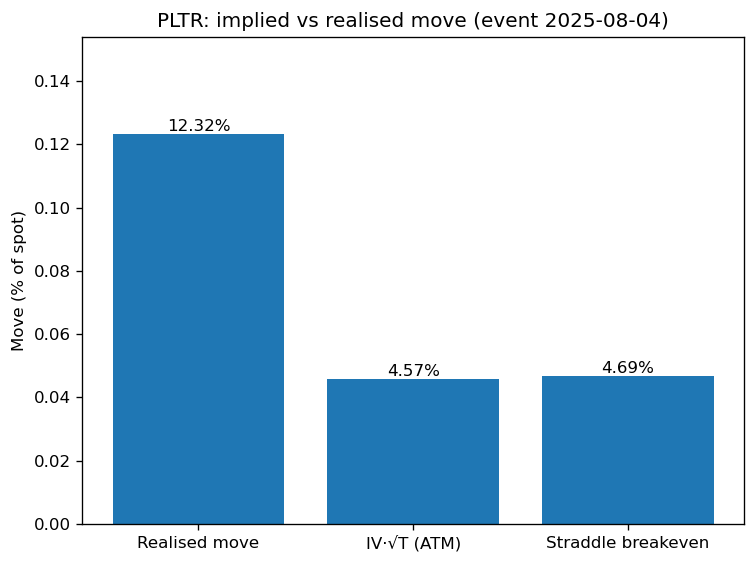

In [11]:
vals = {
    "Realised move": float(realized_move) if pd.notnull(realized_move) else np.nan,
    "IV·√T (ATM)": float(implied_move_iv) if pd.notnull(implied_move_iv) else np.nan,
    "Straddle breakeven": float(breakeven_pct) if pd.notnull(breakeven_pct) else np.nan
}
labels, heights = list(vals.keys()), list(vals.values())

fig, ax = plt.subplots()
ax.bar(labels, heights)
ax.set_ylim(0, max([v for v in heights if pd.notnull(v)]) * 1.25)
ax.set_ylabel("Move (% of spot)")
ax.set_title(f"{TICKER}: implied vs realised move (event {EARN_DATE})")
for i, v in enumerate(heights):
    if pd.notnull(v): ax.text(i, v, f"{v:.2%}", ha="center", va="bottom")
plt.tight_layout()
plt.savefig("figures/implied_vs_realised.png")
plt.show()
